In [2]:
import gc
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import random
import time
import torch
import torch.nn as nn


from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

Using 1 GPU(s)


In [17]:
class config:
    AMP = True
    BATCH_SIZE_TRAIN = 32
    BATCH_SIZE_VALID = 32
    EPOCHS = 5
    FOLDS = 5
    GRADIENT_ACCUMULATION_STEPS = 1
    MAX_GRAD_NORM = 1e7
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    TRAIN_FULL_DATA = False
    VISUALIZE = True
    WEIGHT_DECAY = 0.01
    
    
class paths:
    OUTPUT_DIR = "/home/teerawat.c/projects/HMS_HBAC/log_training"
    TRAIN_CSV = "/home/teerawat.c/projects/HMS_HBAC/datasets/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "/home/teerawat.c/projects/HMS_HBAC/datasets/hms-harmful-brain-activity-classification/train_eegs/"

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def eeg_from_parquet(parquet_path: str, display: bool = False) -> np.ndarray:
    """
    This function reads a parquet file and extracts the middle 50 seconds of readings. Then it fills NaN values
    with the mean value (ignoring NaNs).
    :param parquet_path: path to parquet file.
    :param display: whether to display EEG plots or not.
    :return data: np.array of shape  (time_steps, eeg_features) -> (10_000, 8)
    """
    # === Extract middle 50 seconds ===
    eeg = pd.read_parquet(parquet_path, columns=eeg_features)
    rows = len(eeg)
    offset = (rows - 10_000) // 2 # 50 * 200 = 10_000
    eeg = eeg.iloc[offset:offset+10_000] # middle 50 seconds, has the same amount of readings to left and right
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    # === Convert to numpy ===
    data = np.zeros((10_000, len(eeg_features))) # create placeholder of same shape with zeros
    for index, feature in enumerate(eeg_features):
        x = eeg[feature].values.astype('float32') # convert to float32
        mean = np.nanmean(x) # arithmetic mean along the specified axis, ignoring NaNs
        nan_percentage = np.isnan(x).mean() # percentage of NaN values in feature
        # === Fill nan values ===
        if nan_percentage < 1: # if some values are nan, but not all
            x = np.nan_to_num(x, nan=mean)
        else: # if all values are nan
            x[:] = 0
        data[:, index] = x
        if display: 
            if index != 0:
                offset += x.max()
            plt.plot(range(10_000), x-offset, label=feature)
            offset -= x.min()
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1].split('.')[0]
        plt.yticks([])
        plt.title(f'EEG {name}',size=16)
        plt.show()    
    return data


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    
    
def sep():
    print("-"*100)

    
target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
LOGGER = get_logger()
seed_everything(config.SEED)

In [7]:
train_df = pd.read_csv(paths.TRAIN_CSV)
label_cols = train_df.columns[-6:]
print(f"Train cataframe shape is: {train_df.shape}")
print(f"Labels: {list(label_cols)}")
train_df.head()

Train cataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [358]:
df = pd.read_parquet('/home/teerawat.c/projects/HMS_HBAC/datasets/hms-harmful-brain-activity-classification/train_eegs/1000913311.parquet')
FEATS = df.columns
print(f'There are {len(FEATS)} raw eeg features: {list(FEATS)}')

There are 20 raw eeg features: ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [8]:
eeg_df = pd.read_parquet(paths.TRAIN_EEGS + "100261680.parquet")
eeg_features = eeg_df.columns
print(f'There are {len(eeg_features)} raw eeg features')
print(list(eeg_features))
eeg_features = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
feature_to_index = {x:y for x,y in zip(eeg_features, range(len(eeg_features)))}

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


0it [00:00, ?it/s]

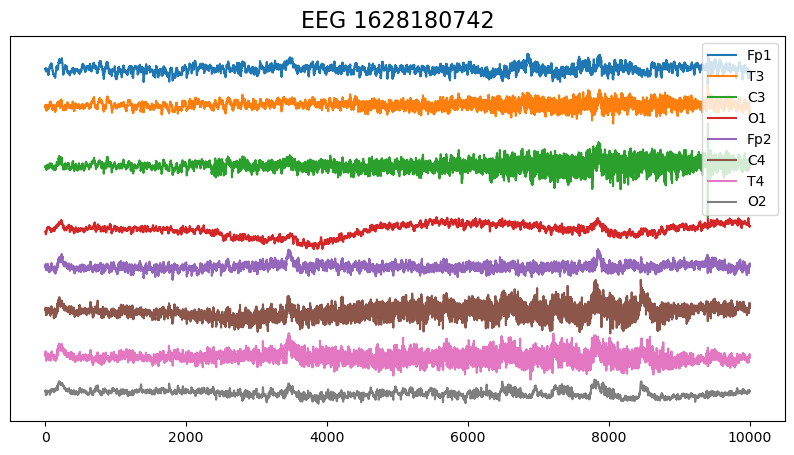

1it [00:01,  1.01s/it]


Reading 17089 eeg NumPys from disk.


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/brain-eegs/eegs.npy'

In [9]:
%%time

CREATE_EEGS = False
all_eegs = {}
visualize = 1
eeg_paths = glob(paths.TRAIN_EEGS + "*.parquet")
eeg_ids = train_df.eeg_id.unique()

for i, eeg_id in tqdm(enumerate(eeg_ids)):  
    # Save EEG to Python dictionary of numpy arrays
    eeg_path = paths.TRAIN_EEGS + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path, display=i<visualize)              
    all_eegs[eeg_id] = data
    
    if i == visualize:
        if CREATE_EEGS:
            print(f'Processing {train_df.eeg_id.nunique()} eeg parquets... ',end='')
        else:
            print(f'Reading {len(eeg_ids)} eeg NumPys from disk.')
            break
            
if CREATE_EEGS: 
    np.save('eegs', all_eegs)
else:
    all_eegs = np.load('/kaggle/input/brain-eegs/eegs.npy',allow_pickle=True).item()

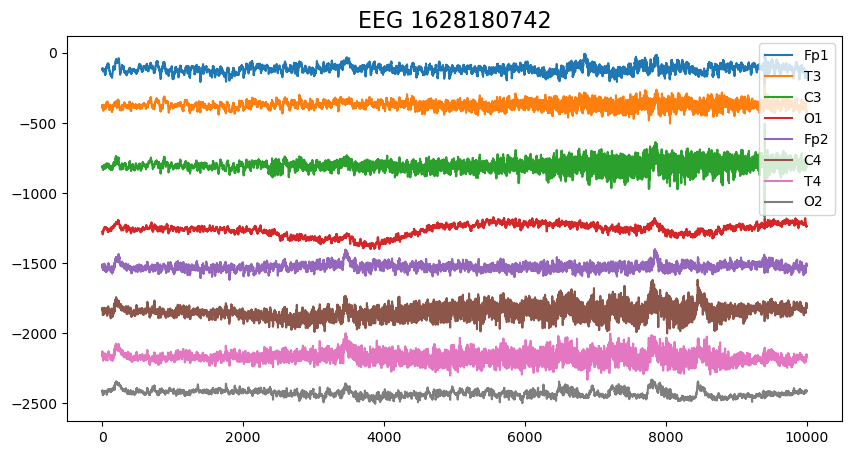

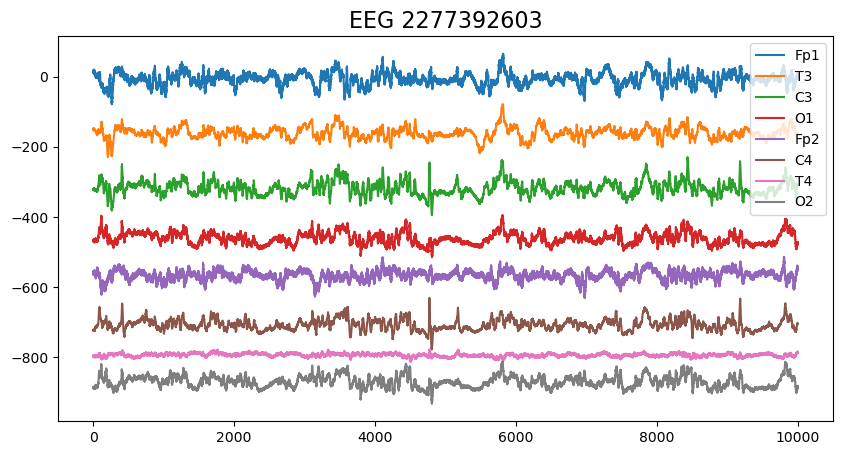

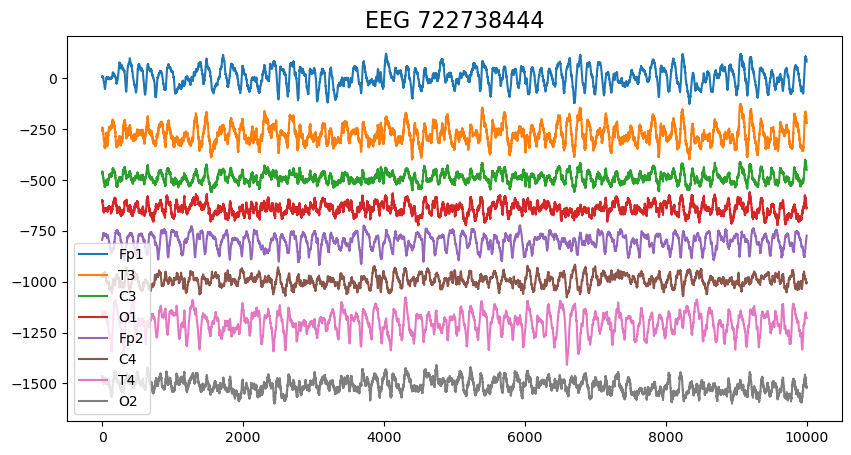

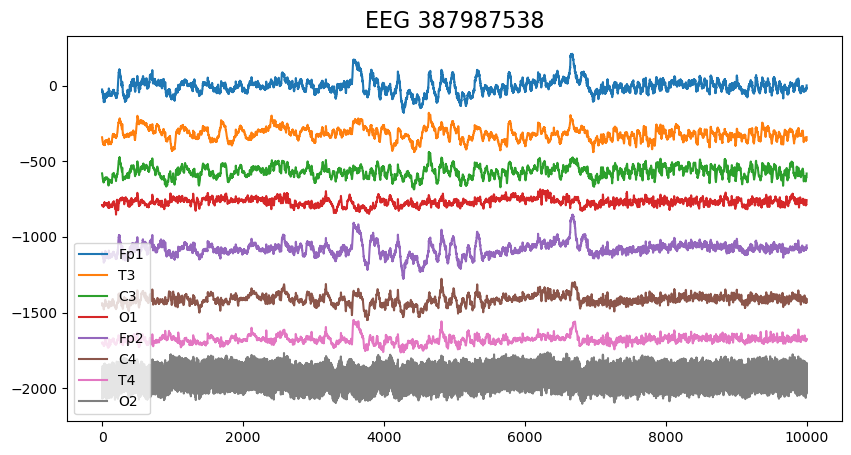

Reading 17089 eeg NumPys from disk.
CPU times: user 7.77 s, sys: 9.3 s, total: 17.1 s
Wall time: 16.7 s


In [361]:
%%time

all_eegs = {}
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
PATH = '/home/teerawat.c/projects/HMS_HBAC/datasets/hms-harmful-brain-activity-classification/train_eegs/'

for i,eeg_id in enumerate(EEG_IDS):
    if (i%100==0)&(i!=0): print(i,', ',end='') 
    
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{PATH}{eeg_id}.parquet', display=i<DISPLAY)              
    all_eegs[eeg_id] = data
    
    if i==DISPLAY:
        if CREATE_EEGS:
            print(f'Processing {train.eeg_id.nunique()} eeg parquets... ',end='')
        else:
            print(f'Reading {len(EEG_IDS)} eeg NumPys from disk.')
            break
            
if CREATE_EEGS: 
    np.save('eegs',all_eegs)
else:
    all_eegs = np.load('/home/teerawat.c/projects/HMS_HBAC/datasets/brain-eegs/eegs.npy',allow_pickle=True).item()

In [10]:
# Deduplicate Train EEG Id

df = pd.read_csv(paths.TRAIN_CSV)
label_cols = df.columns[-6:]

train_df = df.groupby('eeg_id')[['patient_id']].agg('first')
aux = df.groupby('eeg_id')[label_cols].agg('sum') 

for label in label_cols:
    train_df[label] = aux[label].values
    
y_data = train_df[label_cols].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train_df[label_cols] = y_data

aux = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train_df['target'] = aux

train_df = train_df.reset_index()
train_df = train_df.loc[train_df.eeg_id.isin(eeg_ids)]
print(f"Train dataframe with unique eeg_id has shape: {train_df.shape}")
train_df.head()

Train dataframe with unique eeg_id has shape: (17089, 9)


,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [11]:
from sklearn.model_selection import KFold, GroupKFold

gkf = GroupKFold(n_splits=config.FOLDS)
for fold, (train_index, valid_index) in enumerate(gkf.split(train_df, train_df.target, train_df.patient_id)):
    train_df.loc[valid_index, "fold"] = int(fold)
    
display(train_df.groupby('fold').size()), sep()
display(train_df.head())

fold
0.0    3418
1.0    3418
2.0    3418
3.0    3418
4.0    3417
dtype: int64

----------------------------------------------------------------------------------------------------


,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,fold
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other,4.0
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD,2.0
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,4.0
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD,2.0
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,2.0


In [12]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq: int = 20, sampling_rate: int = 200, order: int = 4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

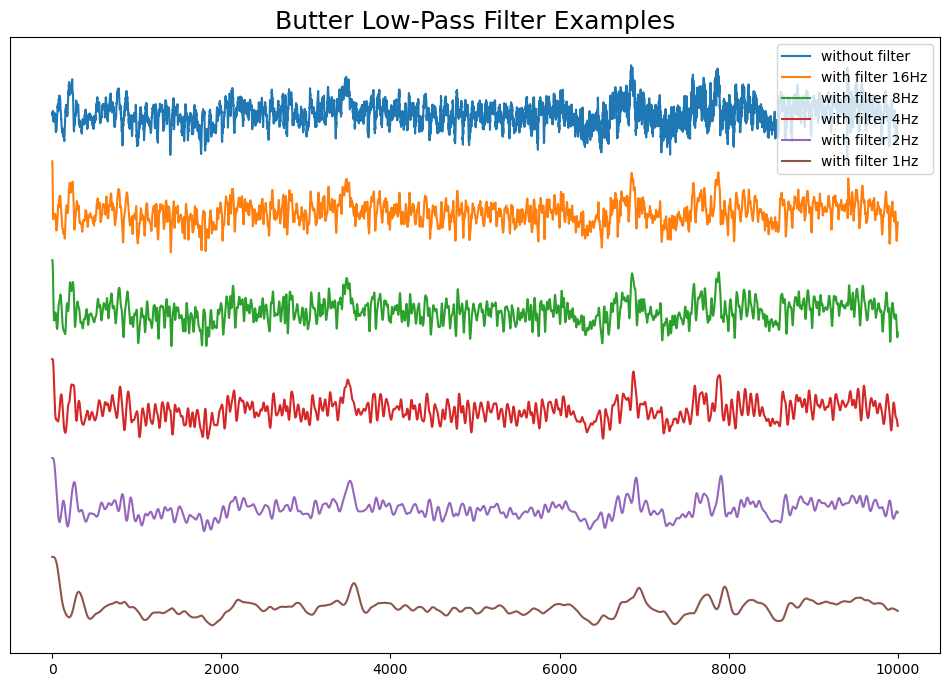

In [13]:
frequencies = [1,2,4,8,16][::-1] # frequencies in Hz
x = [all_eegs[eeg_ids[0]][:,0]] # select one EEG feature

for frequency in frequencies:
    x.append(butter_lowpass_filter(x[0], cutoff_freq=frequency))

plt.figure(figsize=(12,8))
plt.plot(range(10_000), x[0], label='without filter')
for k in range(1,len(x)):
    plt.plot(range(10_000),x[k]-k*(x[0].max()-x[0].min()), label=f'with filter {frequencies[k-1]}Hz')

plt.legend()
plt.yticks([])
plt.title('Butter Low-Pass Filter Examples',size=18)
plt.show()

In [14]:
class CustomDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame, config, mode: str = 'train',
        eegs: Dict[int, np.ndarray] = all_eegs, downsample: int = 5
    ): 
        self.df = df
        self.config = config
        self.batch_size = self.config.BATCH_SIZE_TRAIN
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X, y = self.__data_generation(index)
        X = X[::self.downsample,:]
        output = {
            "X": torch.tensor(X, dtype=torch.float32),
            "y": torch.tensor(y, dtype=torch.float32)
        }
        return output
                        
    def __data_generation(self, index):
        row = self.df.iloc[index]
        X = np.zeros((10_000, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        data = self.eegs[row.eeg_id]

        # === Feature engineering ===
        X[:,0] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['T3']]
        X[:,1] = data[:,feature_to_index['T3']] - data[:,feature_to_index['O1']]

        X[:,2] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['C3']]
        X[:,3] = data[:,feature_to_index['C3']] - data[:,feature_to_index['O1']]

        X[:,4] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['C4']]
        X[:,5] = data[:,feature_to_index['C4']] - data[:,feature_to_index['O2']]

        X[:,6] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['T4']]
        X[:,7] = data[:,feature_to_index['T4']] - data[:,feature_to_index['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        X = butter_lowpass_filter(X)
        
        if self.mode != 'test':
            y = row[label_cols].values.astype(np.float32)
            
        return X, y

In [16]:
train_dataset = CustomDataset(train_df, config, mode="train")
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE_TRAIN,
    shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
)
output = train_dataset[0]
X, y = output["X"], output["y"]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

KeyError: 568657

In [366]:
class EEGDataset(Dataset):
    'EEG Dataset for PyTorch'
    def __init__(self, data, eegs, mode='train', downsample=5):
        self.data = data
        self.eegs = eegs
        self.mode = mode
        self.downsample = downsample
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        row = self.data.iloc[index]
        data = self.eegs[row.eeg_id]
        
        # Adapted feature engineering process
        X = self.feature_engineering(data)
        
        if self.mode != 'test':
            y = row[TARGETS].values.astype('float32')  # Ensure TARGETS is defined as your label columns
            return X, torch.from_numpy(y)
        else:
            return X

    def feature_engineering(self, data):
        sample = np.zeros((10000, 8), dtype='float32')  # Assuming data shape and desired sample shape
        
        # Implementing the feature engineering as specified
        sample[:,0] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['T3']]
        sample[:,1] = data[:,FEAT2IDX['T3']] - data[:,FEAT2IDX['O1']]
        sample[:,2] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['C3']]
        sample[:,3] = data[:,FEAT2IDX['C3']] - data[:,FEAT2IDX['O1']]
        sample[:,4] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['C4']]
        sample[:,5] = data[:,FEAT2IDX['C4']] - data[:,FEAT2IDX['O2']]
        sample[:,6] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['T4']]
        sample[:,7] = data[:,FEAT2IDX['T4']] - data[:,FEAT2IDX['O2']]

        # Applying further preprocessing steps (e.g., clipping, normalization, and filtering) as in the original class
        sample = np.clip(sample, -1024, 1024)
        sample = np.nan_to_num(sample, nan=0) / 32.0
        sample = butter_lowpass_filter(sample)
        
        # Downsample and convert to tensor
        sample = sample[::self.downsample, :]
        return torch.from_numpy(sample).float()

# Example of initializing dataset and dataloader with your parameters
eeg_dataset = EEGDataset(data=train, eegs=all_eegs, mode='train')
eeg_dataloader = DataLoader(eeg_dataset, batch_size=32, shuffle=False)

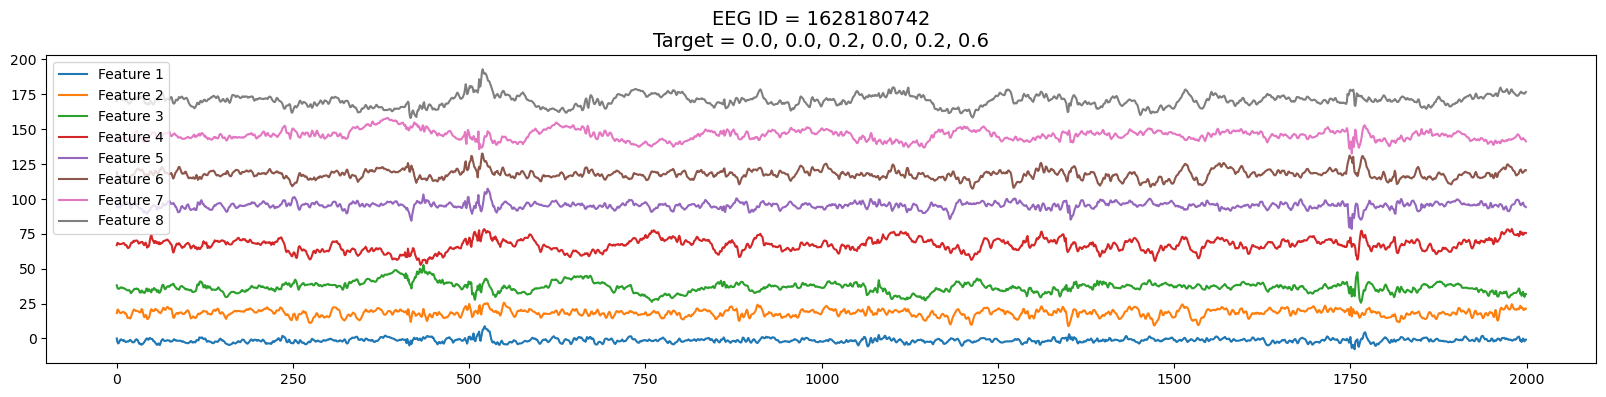

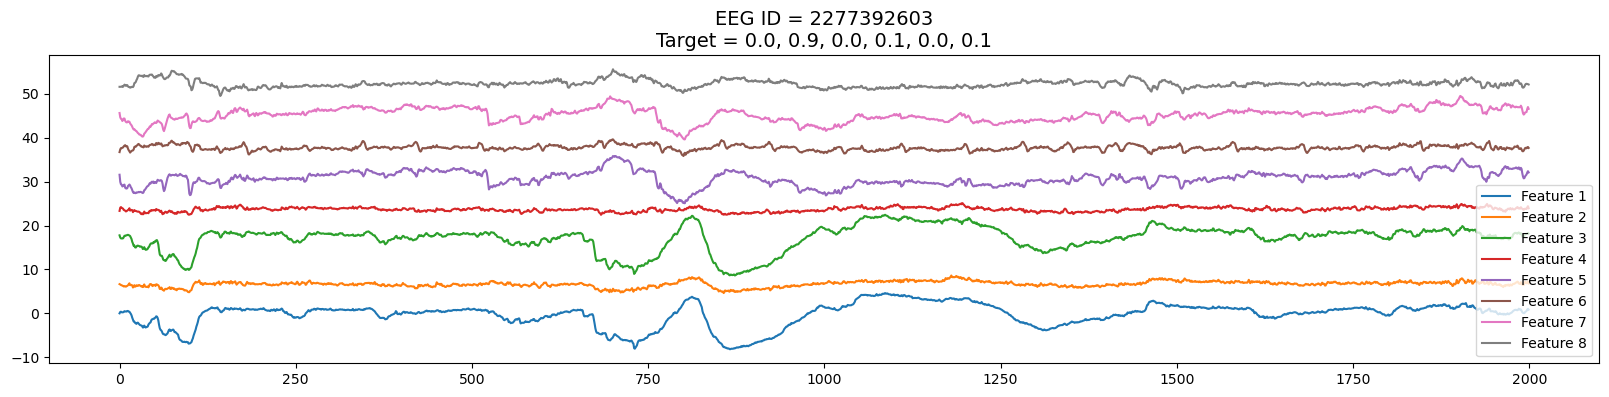

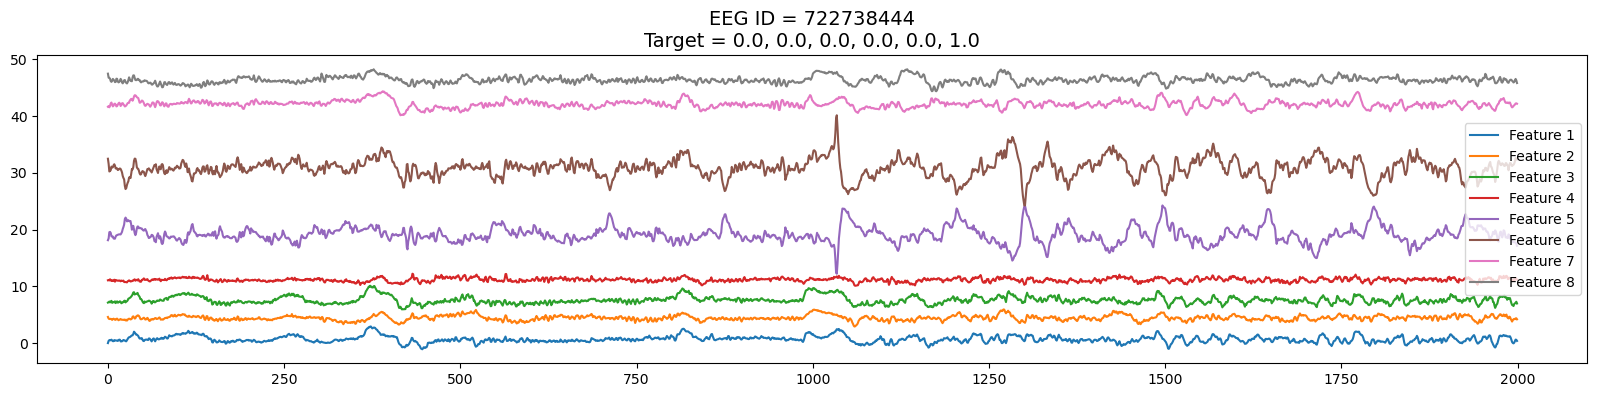

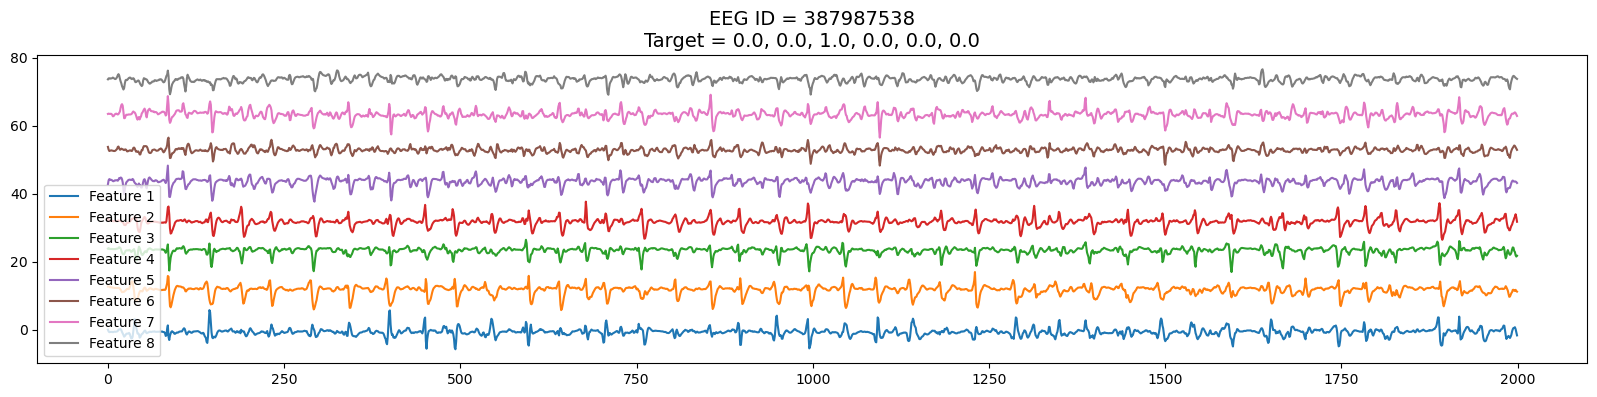

In [401]:
for batch_idx, (x, y) in enumerate(eeg_dataloader):
    # x: features, y: targets
    # Convert x and y back to numpy for visualization if they're tensors
    x = x.numpy()  # Convert tensors to numpy arrays for plotting
    y = y.numpy()

    for k in range(4):  # Assuming you want to plot for the first 4 samples in the batch
        plt.figure(figsize=(20, 4))
        offset = 0
        for j in range(x.shape[-1]):  # Iterate over the last dimension for features
            if j != 0: offset -= x[k, :, j].min()
            plt.plot(range(x.shape[1]), x[k, :, j] + offset, label=f'Feature {j + 1}')  # Adjust range to match downsampled size
            offset += x[k, :, j].max()

        tt = f'{y[k][0]:0.1f}'
        for t in y[k][1:]:
            tt += f', {t:0.1f}'

        # Assuming you have a way to access or generate EEG_IDS for plotting
        plt.title(f'EEG ID = {EEG_IDS[k] if len(EEG_IDS) > k else "Unknown"}\nTarget = {tt}', size=14)
        plt.legend()
        plt.show()

    if batch_idx == 0:  # Only process the first batch
        break

In [402]:
len(eeg_dataset), eeg_dataset.__getitem__(0)

(17089,
 (tensor([[-0.0186,  0.0168, -0.0133,  ..., -0.0195, -0.0248,  0.0136],
          [-2.7153,  2.4285, -1.9531,  ..., -3.0226, -3.8808,  2.0654],
          [-3.5945,  2.5021, -2.5035,  ..., -4.2928, -5.5799,  2.2484],
          ...,
          [-2.1004,  2.7206, -8.2896,  ...,  0.6811, -3.9549,  5.3968],
          [-0.8810,  3.3787, -6.3798,  ...,  1.3858, -4.2617,  6.1737],
          [-0.8026,  3.2428, -6.2627,  ...,  1.2895, -5.2117,  6.6640]]),
  tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.1667, 0.5833])))

In [369]:
dataset = EEGDataset(data=train, eegs=all_eegs, mode='train')

valid_size = int(0.2 * len(dataset))  # for a 80-20 split
train_size = len(dataset) - valid_size

In [370]:
train_size, valid_size

(13672, 3417)

In [371]:
from torch.utils.data import random_split
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

In [372]:
training_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
validation_loader = DataLoader(valid_dataset, shuffle=False, batch_size=32)

In [403]:
class Wave_Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dilation_rates: int, kernel_size: int = 3):
        """
        WaveNet building block.
        :param in_channels: number of input channels.
        :param out_channels: number of output channels.
        :param dilation_rates: how many levels of dilations are used.
        :param kernel_size: size of the convolving kernel.
        """
        super(Wave_Block, self).__init__()
        self.num_rates = dilation_rates
        self.convs = nn.ModuleList()
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.convs.append(nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=True))
        
        dilation_rates = [2 ** i for i in range(dilation_rates)]
        for dilation_rate in dilation_rates:
            self.filter_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.gate_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.convs.append(nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=True))
        
        for i in range(len(self.convs)):
            nn.init.xavier_uniform_(self.convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.convs[i].bias)

        for i in range(len(self.filter_convs)):
            nn.init.xavier_uniform_(self.filter_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.filter_convs[i].bias)

        for i in range(len(self.gate_convs)):
            nn.init.xavier_uniform_(self.gate_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.gate_convs[i].bias)

    def forward(self, x):
        x = self.convs[0](x)
        res = x
        for i in range(self.num_rates):
            tanh_out = torch.tanh(self.filter_convs[i](x))
            sigmoid_out = torch.sigmoid(self.gate_convs[i](x))
            x = tanh_out * sigmoid_out
            x = self.convs[i + 1](x) 
            res = res + x
        return res
    
class WaveNet(nn.Module):
    def __init__(self, input_channels: int = 1, kernel_size: int = 3):
        super(WaveNet, self).__init__()
        self.model = nn.Sequential(
                Wave_Block(input_channels, 8, 12, kernel_size),
                Wave_Block(8, 16, 8, kernel_size),
                Wave_Block(16, 32, 4, kernel_size),
                Wave_Block(32, 64, 1, kernel_size) 
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 1) 
        output = self.model(x)
        return output


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model = WaveNet()
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.dropout = 0.0
        self.head = nn.Sequential(
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(64, 6)
        )
        
    def forward(self, x: torch.Tensor):
        """
        Forwward pass.
        """
        x1 = self.model(x[:, :, 0:1])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 1:2])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z1 = torch.mean(torch.stack([x1, x2]), dim=0)

        x1 = self.model(x[:, :, 2:3])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 3:4])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z2 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        x1 = self.model(x[:, :, 4:5])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 5:6])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z3 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        x1 = self.model(x[:, :, 6:7])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze()
        x2 = self.model(x[:, :, 7:8])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze()
        z4 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        y = torch.cat([z1, z2, z3, z4], dim=1)
        y = self.head(y)
        
        return y

model = CustomModel()
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 98086


Maximum LR: 0.001 | Minimum LR: 4.0000000000000003e-07


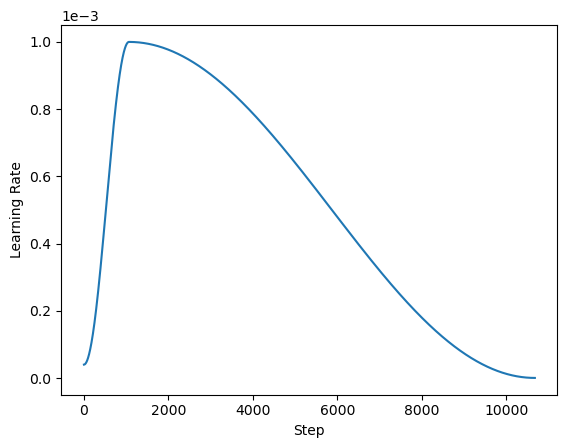

In [404]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 20
BATCHES = len(train_loader)
steps = []
lrs = []
optim_lrs = []
model = CustomModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy="cos",
    final_div_factor=100,
)
for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCHES + batch)

max_lr = max(lrs)
min_lr = min(lrs)
print(f"Maximum LR: {max_lr} | Minimum LR: {min_lr}")
plt.figure()
plt.plot(steps, lrs, label='OneCycle')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()

In [389]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WaveBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_depth):
        super(WaveBlock, self).__init__()
        self.kernel_size = kernel_size
        self.dilation_depth = dilation_depth
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.initial_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        
        self.dilated_convs_tanh = nn.ModuleList([
            nn.Conv1d(out_channels, out_channels, kernel_size, padding='same', dilation=2**i)
            for i in range(dilation_depth)
        ])
        
        self.dilated_convs_sigmoid = nn.ModuleList([
            nn.Conv1d(out_channels, out_channels, kernel_size, padding='same', dilation=2**i)
            for i in range(dilation_depth)
        ])
        
        self.residual_convs = nn.ModuleList([
            nn.Conv1d(out_channels, out_channels, kernel_size=1, padding='same')
            for i in range(dilation_depth)
        ])
        
    def forward(self, x):
        x = self.initial_conv(x)
        res_x = x
        for i in range(self.dilation_depth):
            tanh_out = torch.tanh(self.dilated_convs_tanh[i](x))
            sigm_out = torch.sigmoid(self.dilated_convs_sigmoid[i](x))
            x = tanh_out * sigm_out
            x = self.residual_convs[i](x)
            res_x = res_x + x
        return res_x

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.wave_block1 = WaveBlock(1, 8, 3, 12)
        self.wave_block2 = WaveBlock(8, 16, 3, 8)
        self.wave_block3 = WaveBlock(16, 32, 3, 4)
        self.wave_block4 = WaveBlock(32, 64, 3, 1)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dense1 = nn.Linear(256, 64) # Combining 4 channels of 64 each
        self.dense2 = nn.Linear(64, 6)
        
    def forward(self, x):
        chains = []
        for i in range(8): # Process each channel with the same wave block
            _x = x[:, i:i+1, :] # Selecting each channel
            _x = self.wave_block1(_x)
            _x = self.wave_block2(_x)
            _x = self.wave_block3(_x)
            _x = self.wave_block4(_x)
            _x = self.global_pool(_x).squeeze(-1)
            if i % 2 == 1: # Combining every two channels
                _x = (_x + chains.pop()) / 2
            chains.append(_x)
        
        x = torch.cat(chains, dim=1) # Concatenate all channels
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x

# Assuming you're using some kind of loss function and optimizer
model = MyModel()


In [405]:
import torch.nn.functional as F

# === Reduction = "mean" ===
criterion = nn.KLDivLoss(reduction="mean")
y_pred = F.log_softmax(torch.randn(6, 2, requires_grad=True), dim=1)
y_true = F.softmax(torch.rand(6, 2), dim=1)
print(f"Predictions: {y_pred}")
print(f"Targets: {y_true}")
output = criterion(y_pred, y_true)
print(f"Output: {output}")

print("\n", "="*100, "\n")

# === Reduction = "batchmean" ===
criterion = nn.KLDivLoss(reduction="batchmean")
y_pred = F.log_softmax(torch.randn(2, 6, requires_grad=True), dim=1)
y_true = F.softmax(torch.rand(2, 6), dim=1)
print(f"Predictions: {y_pred}")
print(f"Targets: {y_true}")
output = criterion(y_pred, y_true)
print(f"Output: {output}")

Predictions: tensor([[-1.2756, -0.3275],
        [-1.4250, -0.2751],
        [-0.2587, -1.4785],
        [-1.1612, -0.3756],
        [-0.1377, -2.0505],
        [-2.1117, -0.1290]], grad_fn=<LogSoftmaxBackward0>)
Targets: tensor([[0.5463, 0.4537],
        [0.4164, 0.5836],
        [0.4525, 0.5475],
        [0.5176, 0.4824],
        [0.4996, 0.5004],
        [0.5063, 0.4937]])
Output: 0.11672374606132507


Predictions: tensor([[-2.2520, -1.3175, -3.5549, -2.4936, -1.5375, -1.2010],
        [-2.3877, -3.2783, -2.3787, -2.0035, -2.6488, -0.5583]],
       grad_fn=<LogSoftmaxBackward0>)
Targets: tensor([[0.1156, 0.1924, 0.1313, 0.1149, 0.2299, 0.2159],
        [0.1806, 0.1477, 0.2733, 0.1204, 0.1379, 0.1401]])
Output: 0.31501734256744385


In [390]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

MyModel(
  (wave_block1): WaveBlock(
    (initial_conv): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
    (dilated_convs_tanh): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same)
      (1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
      (2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same, dilation=(4,))
      (3): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same, dilation=(8,))
      (4): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same, dilation=(16,))
      (5): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same, dilation=(32,))
      (6): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same, dilation=(64,))
      (7): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same, dilation=(128,))
      (8): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same, dilation=(256,))
      (9): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same, dilation=(512,))
      (10): Conv1d(8, 8, ke

In [352]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# EEGNet = EEGNet().to(device)
# print(f"Model is using device: {device}", f"{EEGNet}")

Model is using device: cuda EEGNet(
  (conv1): Conv1d(2000, 32, kernel_size=(32,), stride=(2,), padding=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv1d(32, 64, kernel_size=(16,), stride=(1,), padding=(8,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=(4,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv1d(128, 256, kernel_size=(4,), stride=(1,), padding=(2,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU(inplace=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (pool): Adaptive

In [375]:
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F

In [409]:
from sklearn.metrics import accuracy_score, f1_score
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ModelTraining:
    def __init__(self, epochs, model, training_loader, validation_loader, learning_rate=0.0008):
        self.epochs = epochs
        self.model = model.to(device)
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.best_weights = None
        self.best_vloss = float('inf')


        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
        # self.loss_fn = torch.nn.KLDivLoss(reduction='batchmean')
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def train_one_epoch(self, epoch_index, tb_writer):
        self.model.train()  # Set model to training mode
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(self.training_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(self.training_loader)
        print(f'Epoch {epoch_index + 1}, Training loss: {avg_loss:.4f}')
        tb_writer.add_scalar('Loss/train', avg_loss, epoch_index)

        return avg_loss

    def evaluate(self):
        self.model.eval()  # Set model to evaluation mode
        running_vloss = 0.0
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for inputs, labels in self.validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                vloss = self.loss_fn(outputs, labels)
                running_vloss += vloss.item()
                
                labels = labels.argmax(dim=1)
                pred_labels = outputs.argmax(dim=1)
                
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(pred_labels.cpu().numpy())

        avg_vloss = running_vloss / len(self.validation_loader)
        accuracy = accuracy_score(true_labels, predicted_labels)
        print(f'Validation Loss: {avg_vloss:.4f}, Accuracy: {accuracy:.4f}')

        return avg_vloss, accuracy

    def train(self):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        writer = SummaryWriter(f'runs/eegnet_trainer_{timestamp}')

        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            avg_loss = self.train_one_epoch(epoch, writer)
            avg_vloss, accuracy = self.evaluate()

            writer.add_scalars('Loss', {'Validation': avg_vloss, 'Accuracy': accuracy}, epoch)

            if avg_vloss < self.best_vloss:
                self.best_vloss = avg_vloss
                self.best_weights = self.model.state_dict()

        writer.close()
        print('Training complete.')

In [410]:
EEGNet_log = ModelTraining(epochs=20, model=model, training_loader=training_loader, validation_loader=validation_loader)
EEGNet_log.train()

Epoch 1/20
Epoch 1, Training loss: 1.4364
Validation Loss: 1.8343, Accuracy: 0.4694
Epoch 2/20
Epoch 2, Training loss: 1.1883
Validation Loss: 1.3213, Accuracy: 0.5522
Epoch 3/20
Epoch 3, Training loss: 1.1175
Validation Loss: 1.2510, Accuracy: 0.5935
Epoch 4/20
Epoch 4, Training loss: 1.1012
Validation Loss: 1.9199, Accuracy: 0.3433
Epoch 5/20
Epoch 5, Training loss: 1.1154
Validation Loss: 1.8121, Accuracy: 0.5010
Epoch 6/20
Epoch 6, Training loss: 1.1346
Validation Loss: 1.5405, Accuracy: 0.4077
Epoch 7/20
Epoch 7, Training loss: 1.1526
Validation Loss: 1.5953, Accuracy: 0.4814
Epoch 8/20
Epoch 8, Training loss: 1.3339
Validation Loss: 2.0282, Accuracy: 0.4363
Epoch 9/20
Epoch 9, Training loss: 1.4857
Validation Loss: 1.8541, Accuracy: 0.4053
Epoch 10/20
Epoch 10, Training loss: 1.4967
Validation Loss: 2.5409, Accuracy: 0.4530
Epoch 11/20
Epoch 11, Training loss: 1.4191
Validation Loss: 6.6618, Accuracy: 0.4267
Epoch 12/20
Epoch 12, Training loss: 1.3530
Validation Loss: 6.9071, Acc

KeyboardInterrupt: 